###### Notebook 14:  Ising Phases using Convolutional Neural Networks in PyTorch 

## Learning Goal
The primary goal of this notebooks is to learn how to implement a Convolutional Neural Network (CNN) using the powerful PyTorch package. It also introduces core concepts for CNNs such as convolutional and pooling layers and padding.

## Overview
In this notebook, we will write a simple convolutional neural network (CNN) in Pytorch for classifying phases for the Ising Model. We will consider perhaps the simplest CNN: a single convolutional layer with depth $N \in \{1,5,10,20,50\}$. This will introduce the power of the Pytorch framework to make dynamic graphs. 

We will use this notebook to characterize samples drawn from the 2D Ising model at various temperatures. This is the same dataset that has been used in all earlier examples. Recall that the critical temperature for the Ising model is $T_c=2.26$.

In [1]:
from __future__ import print_function, division
import os,sys
import numpy as np
import torch # pytorch package, allows using GPUs
# fix seed
seed=17
np.random.seed(seed)
torch.manual_seed(seed)

## Structure of the Procedure

Constructing a Deep Neural Network to solve ML problems is a multiple-stage process. Quite generally, one can identify the key steps as follows:

* ***step 1:*** Load and process the data
* ***step 2:*** Define the model and its architecture
* ***step 3:*** Choose the optimizer and the cost function
* ***step 4:*** Train the model 
* ***step 5:*** Evaluate the model performance on the *unseen* test data
* ***step 6:*** Modify the hyperparameters to optimize performance for the specific data set

Below, we sometimes combine some of these steps together for convenience.

### Step 1: Load and Process the Ising Dataset

We start by defining the dataset class for Pytorch.

We have three types of samples in the Ising dataset: samples drawn from deep in the disordered phase, samples drawn from the ordered phase, and samples drawn from near the critical phase which we do not use for training. The goal is to classify whether a sample comes from $T>T_c$ or $T<T_c$.

There is standard way to load data when using the PyTorch package, which we discussed in the DNN example for the SUSY dataset. Here, we just switch to the 2D-Ising data instead.

To proceed, download the Ising dataset and insert the proper `path_to_data` in the script.

In [2]:
from torchvision import datasets # load data
from urllib.request import urlopen 

class Ising_Dataset(torch.utils.data.Dataset):
    """Ising pytorch dataset."""

    def __init__(self, data_type, transform=False):
        """
        Args:
            data_type (string): `train`, `test` or `critical`: creates data_loader
            transform (callable, optional): Optional transform to be applied on a sample.

        """

        from sklearn.model_selection import train_test_split
        import collections
        import pickle as pickle


        L=40 # linear system size
        T=np.linspace(0.25,4.0,16) # temperatures
        T_c=2.26 # critical temperature in the TD limit

        url_main = 'https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/';

        ######### LOAD DATA
        # The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
        data_file_name = "Ising2DFM_reSample_L40_T=All.pkl" 
        # The labels are obtained from the following file:
        label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"

        #DATA
        data = pickle.load(urlopen(url_main + data_file_name)) # pickle reads the file and returns the Python object (1D array, compressed bits)
        data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
        data=data.astype('int')
        data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

        #LABELS (convention is 1 for ordered states and 0 for disordered states)
        labels = pickle.load(urlopen(url_main + label_file_name)) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)

        # divide data into ordered, critical and disordered

        X_ordered=data[:70000,:]
        Y_ordered=labels[:70000]

        X_critical=data[70000:100000,:]
        Y_critical=labels[70000:100000]

        X_disordered=data[100000:,:]
        Y_disordered=labels[100000:]

        del data,labels
        # define training, critical and test data sets
        X=np.concatenate((X_ordered,X_disordered)) #np.concatenate((X_ordered,X_critical,X_disordered))
        Y=np.concatenate((Y_ordered,Y_disordered)) #np.concatenate((Y_ordered,Y_critical,Y_disordered))

        # pick random data points from ordered and disordered states to create the training and test sets
        X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,train_size=0.8)


        if data_type=='train':
            X=X_train
            Y=Y_train
            print("Training on 80 percent of examples")

        if data_type=='test':
            X=X_test
            Y=Y_test
            print("Testing on 20 percent of examples")

        if data_type=='critical':
            X=X_critical
            Y=Y_critical
            print("Predicting on %i critical examples"%len(Y_critical))

        # reshape data back to original 2D-array form
        X=X.reshape(X.shape[0],40,40)

        # these are necessary attributes in dataset class and must be assigned
        self.data=(X,Y)
        self.transform = transform


    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, idx):

        sample=(self.data[0][idx,...],self.data[1][idx])
        if self.transform:
            sample=self.transform(sample)

        return sample

    
def load_data(kwargs):
    # kwargs:  CUDA arguments, if enabled
    # load and noralise train,test, and data
    train_loader = torch.utils.data.DataLoader(
        Ising_Dataset(data_type='train'),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        Ising_Dataset(data_type='test'),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    critical_loader = torch.utils.data.DataLoader(
        Ising_Dataset(data_type='critical'),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader, critical_loader

### Step 2: Define the Neural Net and its Architecture

Similar to the discussion in the SUSY DNN notebook, we then define the architecture of the neural net in the `model` class which contains the `forward` function method that tells us how to produce the output given some input. The backpropagaiton algorithm is implemented automatically by the Pytorch package.

Recall that a CNN is composed of convolutional layers, max-pool layer, often followed by a fully connected layer and then the classifier. In the architecture below, we start with a convolutional layer that takes as an input a layer with $D_{in}=1$ with height and width $H=W=40$, a receptive field or filter size of $2 \times 2$, and depth $N$ (there are $N$ layers). We also add a padding of zeros on both sides of the image.  This convolutional layer can be summarized by the four numbers $[N,D_{in},H,W]=[N,1,41,41]$. This is then fed into a $2 \times 2$ maxpool layer which results in layer of size $[N,1,20,20]$. This layer is then hooked up to a linear layer that takes as an `[input,output]` of the form `[N*20*20*1,2]` since there are $2$ classes (corresponding to the ordered and disordered phases). We use a logistic (softmax) classifier as the output and train using various optimizers.

In [3]:
import torch.nn as nn # construct NN

class model(nn.Module):
    # create convolutional net
    def __init__(self, N=10, L=40):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()	
        # create convolutional layer with input depth 1 and output depth N
        self.conv1 = nn.Conv2d(1, N, kernel_size=2, padding=1)
        # batch norm layer takes Depth
        self.bn1=nn.BatchNorm2d(N) 
        # create fully connected layer after maxpool operation reduced 40->18
        self.fc1 = nn.Linear(20*20*N, 2) 	
        self.N=N
        self.L=L
        print("The number of neurons in CNN layer is %i"%(N))

    def forward(self, x):
        #Unsqueeze command indicates one channel and turns x.shape from (:,40,40) to (:,1, 40,40)
        x=F.relu(self.conv1(torch.unsqueeze(x,1).float()))
        #print(x.shape)  often useful to look at shapes for debugging
        x = F.max_pool2d(x,2)	 
        #print(x.shape)
        x=self.bn1(x) # largely unnecessary and here just for pedagogical purposes
        return F.log_softmax(self.fc1(x.view(-1,20*20*self.N)), dim=1)

In [4]:
import torch.nn as nn # construct NN

class model_pbc(nn.Module):
    # create convolutional net
    def __init__(self, N=10, L=40):
        # inherit attributes and methods of nn.Module
        super(model_pbc, self).__init__()	
        # create convolutional layer with input depth 1 and output depth N
        self.conv1 = nn.Conv2d(1, N, kernel_size=2)
        # batch norm layer takes Depth
        self.bn1=nn.BatchNorm2d(N) 
        # create fully connected layer after maxpool operation reduced 40->18
        self.fc1 = nn.Linear(20*20*N, 2) 	
        self.N=N
        self.L=L
        print("The number of neurons in CNN layer is %i"%(N))

    def forward(self, x):
        #Unsqueeze command indicates one channel and turns x.shape from (:,40,40) to (:,1, 40,40)
        x=F.pad(torch.unsqueeze(x,1).float(), [0,1,0,1], "circular")
        x=F.relu(self.conv1(x))
        #print(x.shape)  often useful to look at shapes for debugging
        x = F.max_pool2d(x,2)	 
        #print(x.shape)
        x=self.bn1(x) # largely unnecessary and here just for pedagogical purposes
        return F.log_softmax(self.fc1(x.view(-1,20*20*self.N)), dim=1)

#### Define the `train` and `test` functions

These are very standard functions for going over data to train and evaluate the model. 

Since we will be testing the CNN performance on both the test and the critical data, the `test` function accepts two arguments: `data_loader` and `verbose` to allow control over the input data and the printing messages.

In [5]:
def train(epoch):
    # these are very standard functions for going over data to train

    CNN.train() # effects Dropout and BatchNorm layers
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = CNN(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(data_loader,verbose='Test'):
    # these are very standard functions for evaluating data

    CNN.eval() # effects Dropout and BatchNorm layers
    test_loss = 0
    correct = 0
    for data, target in data_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        output = CNN(data)
        test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(data_loader.dataset)
    print('\n'+verbose+' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    accuracy=100. * correct / len(data_loader.dataset)
    return(accuracy)

#### Define Model Parameters

Next we define the training settings. This proceeds in the same way as in Notebook 13 on the SUSY dataset, except we now also show how to turn on the `cuda` library option of PyTorch which enables parallel coputations (whenever resources for this are available). 

In [6]:
import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

# training settings
parser = argparse.ArgumentParser(description='PyTorch Convmodel Ising Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
args.epochs=5
args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

cuda_kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

### Steps 3+4+5: Choose the Optimizer and the Cost Function. Train and Evaluate the Model.

In [7]:
import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

# load data
train_loader, test_loader, critical_loader=load_data(cuda_kwargs)

test_array=[]
critical_array=[]

# create array of depth of convolutional layer
N_array=[50]

# loop over depths
for N in N_array:
    CNN = model(N=N)
    if args.cuda:
        CNN.cuda()

    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    optimizer = optim.SGD(CNN.parameters(), lr=args.lr, momentum=args.momentum)
    #optimizer = optim.Adam(DNN.parameters(), lr=0.001, betas=(0.9, 0.999))

    # train the CNN and test its performance at each epoch
    for epoch in range(1, args.epochs + 1):
        train(epoch)
        if epoch==args.epochs:
            test_array.append(test(test_loader,verbose='Test'))
            critical_array.append(test(critical_loader,verbose='Critical'))
        else:
            test(test_loader,verbose='Test')
            test(critical_loader,verbose='Critical')
    print(test_array)
    print(critical_array)

Training on 80 percent of examples
Testing on 20 percent of examples
Predicting on 30000 critical examples
The number of neurons in CNN layer is 50
Train Epoch: 1 [0/104000 (0%)]	Loss: 0.963628
Train Epoch: 1 [640/104000 (1%)]	Loss: 0.000000
Train Epoch: 1 [1280/104000 (1%)]	Loss: 0.000000
Train Epoch: 1 [1920/104000 (2%)]	Loss: 0.000000
Train Epoch: 1 [2560/104000 (2%)]	Loss: 0.000000
Train Epoch: 1 [3200/104000 (3%)]	Loss: 0.000000
Train Epoch: 1 [3840/104000 (4%)]	Loss: 0.000000
Train Epoch: 1 [4480/104000 (4%)]	Loss: 0.000000
Train Epoch: 1 [5120/104000 (5%)]	Loss: 0.000000
Train Epoch: 1 [5760/104000 (6%)]	Loss: 0.000000
Train Epoch: 1 [6400/104000 (6%)]	Loss: 0.000000
Train Epoch: 1 [7040/104000 (7%)]	Loss: 0.000000
Train Epoch: 1 [7680/104000 (7%)]	Loss: 0.000000
Train Epoch: 1 [8320/104000 (8%)]	Loss: 0.000000
Train Epoch: 1 [8960/104000 (9%)]	Loss: 0.000000
Train Epoch: 1 [9600/104000 (9%)]	Loss: 0.000000
Train Epoch: 1 [10240/104000 (10%)]	Loss: 0.000000
Train Epoch: 1 [10880

Train Epoch: 1 [103040/104000 (99%)]	Loss: 0.000000
Train Epoch: 1 [103680/104000 (100%)]	Loss: 0.000000


/home/lololobo93/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 2.1973, Accuracy: 24808/30000 (83%)

Train Epoch: 2 [0/104000 (0%)]	Loss: 0.000000
Train Epoch: 2 [640/104000 (1%)]	Loss: 0.000000
Train Epoch: 2 [1280/104000 (1%)]	Loss: 0.000000
Train Epoch: 2 [1920/104000 (2%)]	Loss: 0.000000
Train Epoch: 2 [2560/104000 (2%)]	Loss: 0.000000
Train Epoch: 2 [3200/104000 (3%)]	Loss: 0.000000
Train Epoch: 2 [3840/104000 (4%)]	Loss: 0.000000
Train Epoch: 2 [4480/104000 (4%)]	Loss: 0.000000
Train Epoch: 2 [5120/104000 (5%)]	Loss: 0.000000
Train Epoch: 2 [5760/104000 (6%)]	Loss: 0.000000
Train Epoch: 2 [6400/104000 (6%)]	Loss: 0.000000
Train Epoch: 2 [7040/104000 (7%)]	Loss: 0.000000
Train Epoch: 2 [7680/104000 (7%)]	Loss: 0.000000
Train Epoch: 2 [8320/104000 (8%)]	Loss: 0.000000
Train Epoch: 2 [8960/104000 (9%)]	Loss: 0.000000
Train Epoch: 2 [9600/104000 (9%)]	Loss: 0.000000
Train Epoch: 2 [10240/104000 (10%)]	Loss: 0.000000
Train Epoch: 2 [10880/104000 (10%)]	Loss

Train Epoch: 2 [103040/104000 (99%)]	Loss: 0.000000
Train Epoch: 2 [103680/104000 (100%)]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 1.4588, Accuracy: 25416/30000 (85%)

Train Epoch: 3 [0/104000 (0%)]	Loss: 0.000000
Train Epoch: 3 [640/104000 (1%)]	Loss: 0.000000
Train Epoch: 3 [1280/104000 (1%)]	Loss: 0.000000
Train Epoch: 3 [1920/104000 (2%)]	Loss: 0.000000
Train Epoch: 3 [2560/104000 (2%)]	Loss: 0.000000
Train Epoch: 3 [3200/104000 (3%)]	Loss: 0.000000
Train Epoch: 3 [3840/104000 (4%)]	Loss: 0.000000
Train Epoch: 3 [4480/104000 (4%)]	Loss: 0.000000
Train Epoch: 3 [5120/104000 (5%)]	Loss: 0.000000
Train Epoch: 3 [5760/104000 (6%)]	Loss: 0.000000
Train Epoch: 3 [6400/104000 (6%)]	Loss: 0.000000
Train Epoch: 3 [7040/104000 (7%)]	Loss: 0.000000
Train Epoch: 3 [7680/104000 (7%)]	Loss: 0.000000
Train Epoch: 3 [8320/104000 (8%)]	Loss: 0.000000
Train Epoch: 3 [8960/104000 (9%)]	Loss: 0.000000
Train Epoch: 3 [9600/104000 (9%)]	L

Train Epoch: 3 [101760/104000 (98%)]	Loss: 0.000000
Train Epoch: 3 [102400/104000 (98%)]	Loss: 0.000000
Train Epoch: 3 [103040/104000 (99%)]	Loss: 0.000000
Train Epoch: 3 [103680/104000 (100%)]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 2.1078, Accuracy: 24798/30000 (83%)

Train Epoch: 4 [0/104000 (0%)]	Loss: 0.000000
Train Epoch: 4 [640/104000 (1%)]	Loss: 0.000000
Train Epoch: 4 [1280/104000 (1%)]	Loss: 0.000000
Train Epoch: 4 [1920/104000 (2%)]	Loss: 0.000000
Train Epoch: 4 [2560/104000 (2%)]	Loss: 0.000000
Train Epoch: 4 [3200/104000 (3%)]	Loss: 0.000000
Train Epoch: 4 [3840/104000 (4%)]	Loss: 0.000000
Train Epoch: 4 [4480/104000 (4%)]	Loss: 0.000000
Train Epoch: 4 [5120/104000 (5%)]	Loss: 0.000000
Train Epoch: 4 [5760/104000 (6%)]	Loss: 0.000000
Train Epoch: 4 [6400/104000 (6%)]	Loss: 0.000000
Train Epoch: 4 [7040/104000 (7%)]	Loss: 0.000000
Train Epoch: 4 [7680/104000 (7%)]	Loss: 0.000000
Train Epoch: 4 [8320/104000 (

Train Epoch: 4 [99840/104000 (96%)]	Loss: 0.000000
Train Epoch: 4 [100480/104000 (97%)]	Loss: 0.000000
Train Epoch: 4 [101120/104000 (97%)]	Loss: 0.000000
Train Epoch: 4 [101760/104000 (98%)]	Loss: 0.000000
Train Epoch: 4 [102400/104000 (98%)]	Loss: 0.000000
Train Epoch: 4 [103040/104000 (99%)]	Loss: 0.000000
Train Epoch: 4 [103680/104000 (100%)]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 1.2528, Accuracy: 25713/30000 (86%)

Train Epoch: 5 [0/104000 (0%)]	Loss: 0.000000
Train Epoch: 5 [640/104000 (1%)]	Loss: 0.000000
Train Epoch: 5 [1280/104000 (1%)]	Loss: 0.000000
Train Epoch: 5 [1920/104000 (2%)]	Loss: 0.000000
Train Epoch: 5 [2560/104000 (2%)]	Loss: 0.000000
Train Epoch: 5 [3200/104000 (3%)]	Loss: 0.000000
Train Epoch: 5 [3840/104000 (4%)]	Loss: 0.000000
Train Epoch: 5 [4480/104000 (4%)]	Loss: 0.000000
Train Epoch: 5 [5120/104000 (5%)]	Loss: 0.000000
Train Epoch: 5 [5760/104000 (6%)]	Loss: 0.000000
Train Epoch: 5 [6400/

Train Epoch: 5 [98560/104000 (95%)]	Loss: 0.000000
Train Epoch: 5 [99200/104000 (95%)]	Loss: 0.000000
Train Epoch: 5 [99840/104000 (96%)]	Loss: 0.000000
Train Epoch: 5 [100480/104000 (97%)]	Loss: 0.000000
Train Epoch: 5 [101120/104000 (97%)]	Loss: 0.000000
Train Epoch: 5 [101760/104000 (98%)]	Loss: 0.000000
Train Epoch: 5 [102400/104000 (98%)]	Loss: 0.000000
Train Epoch: 5 [103040/104000 (99%)]	Loss: 0.000000
Train Epoch: 5 [103680/104000 (100%)]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 1.8149, Accuracy: 25020/30000 (83%)

[100.0]
[83.4]


## Plot Accuracy

Let us now plot the accuracy of our calculation. Notice that even with a convolutional layer of depth 1 (one set of weights and a single bias!) we can get a 100% accuracy on the test set. We do less well on the critical data (somewhere between 80-90%) with lots of fluctuations from training run to training to run. Again, this shows you the incredible power and (some of the limitations) of all these ML methods. If the dataset we care about (critical region) is not exactly the dataset we train on, our accuracy can be significantly diminished.

In [ ]:
from matplotlib import pyplot as plt

## Print the result for different N
%matplotlib inline

plt.plot(N_array, test_array, 'r-*', label="test")
plt.plot(N_array, critical_array, 'b-s', label="critical")
plt.ylim(60,110)
plt.xlabel('Depth of hidden layer', fontsize=24)
plt.xticks(N_array)
plt.ylabel('Accuracy', fontsize=24)
plt.legend(loc='best', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.show()

## Exercises

* Do __Step 6__: modify the hyperparameters to optimize performance for the specific data set
* The strides used above do not account for the periodic boundary conditions. Define your own stride function in PyTorch to incorporate periodic boundary conditions

In [ ]:
import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

# load data
train_loader, test_loader, critical_loader=load_data(cuda_kwargs)

test_array=[]
critical_array=[]

# create array of depth of convolutional layer
lr_array=np.logspace(-4,1,6)
N = 20

# loop over depths
for lr in lr_array:
    CNN = model(N=N)
    if args.cuda:
        CNN.cuda()

    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    optimizer = optim.SGD(CNN.parameters(), lr=lr, momentum=args.momentum)
    #optimizer = optim.Adam(DNN.parameters(), lr=0.001, betas=(0.9, 0.999))

    # train the CNN and test its performance at each epoch
    for epoch in range(1, args.epochs + 1):
        train(epoch)
        if epoch==args.epochs:
            test_array.append(test(test_loader,verbose='Test'))
            critical_array.append(test(critical_loader,verbose='Critical'))
        else:
            test(test_loader,verbose='Test')
            test(critical_loader,verbose='Critical')
    print(test_array)
    print(critical_array)

In [ ]:
from matplotlib import pyplot as plt

## Print the result for different N
%matplotlib inline

plt.plot(np.log10(lr_array), test_array, 'r-*', label="test")
plt.plot(np.log10(lr_array), critical_array, 'b-s', label="critical")
plt.ylim(60,110)
plt.xlabel('Learning rate', fontsize=24)
plt.xticks(np.log10(lr_array))
plt.ylabel('Accuracy', fontsize=24)
plt.legend(loc='best', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.show()

In [8]:
import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

# load data
train_loader, test_loader, critical_loader=load_data(cuda_kwargs)

test_array=[]
critical_array=[]

# create array of depth of convolutional layer
lr_array=np.logspace(-4,1,6)
N = 20

# loop over depths
for lr in [10**-1]:
    CNN = model_pbc(N=N)
    if args.cuda:
        CNN.cuda()

    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    optimizer = optim.SGD(CNN.parameters(), lr=args.lr, momentum=args.momentum)
    #optimizer = optim.Adam(DNN.parameters(), lr=0.001, betas=(0.9, 0.999))

    # train the CNN and test its performance at each epoch
    for epoch in range(1, args.epochs + 1):
        train(epoch)
        if epoch==args.epochs:
            test_array.append(test(test_loader,verbose='Test'))
            critical_array.append(test(critical_loader,verbose='Critical'))
        else:
            test(test_loader,verbose='Test')
            test(critical_loader,verbose='Critical')
    print(test_array)
    print(critical_array)

Training on 80 percent of examples
Testing on 20 percent of examples
Predicting on 30000 critical examples
The number of neurons in CNN layer is 20
Train Epoch: 1 [0/104000 (0%)]	Loss: 1.013878
Train Epoch: 1 [640/104000 (1%)]	Loss: 0.001112
Train Epoch: 1 [1280/104000 (1%)]	Loss: 0.000000
Train Epoch: 1 [1920/104000 (2%)]	Loss: 0.000000
Train Epoch: 1 [2560/104000 (2%)]	Loss: 0.000000
Train Epoch: 1 [3200/104000 (3%)]	Loss: 0.000034
Train Epoch: 1 [3840/104000 (4%)]	Loss: 0.000000
Train Epoch: 1 [4480/104000 (4%)]	Loss: 0.000000
Train Epoch: 1 [5120/104000 (5%)]	Loss: 0.000681
Train Epoch: 1 [5760/104000 (6%)]	Loss: 0.000000
Train Epoch: 1 [6400/104000 (6%)]	Loss: 0.000011
Train Epoch: 1 [7040/104000 (7%)]	Loss: 0.000000
Train Epoch: 1 [7680/104000 (7%)]	Loss: 0.000007
Train Epoch: 1 [8320/104000 (8%)]	Loss: 0.001452
Train Epoch: 1 [8960/104000 (9%)]	Loss: 0.000000
Train Epoch: 1 [9600/104000 (9%)]	Loss: 0.000181
Train Epoch: 1 [10240/104000 (10%)]	Loss: 0.000000
Train Epoch: 1 [10880

/home/hadas/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.5128, Accuracy: 25967/30000 (87%)

Train Epoch: 2 [0/104000 (0%)]	Loss: 0.000000
Train Epoch: 2 [640/104000 (1%)]	Loss: 0.000000
Train Epoch: 2 [1280/104000 (1%)]	Loss: 0.000000
Train Epoch: 2 [1920/104000 (2%)]	Loss: 0.000000
Train Epoch: 2 [2560/104000 (2%)]	Loss: 0.000000
Train Epoch: 2 [3200/104000 (3%)]	Loss: 0.000000
Train Epoch: 2 [3840/104000 (4%)]	Loss: 0.000000
Train Epoch: 2 [4480/104000 (4%)]	Loss: 0.000000
Train Epoch: 2 [5120/104000 (5%)]	Loss: 0.000000
Train Epoch: 2 [5760/104000 (6%)]	Loss: 0.000000
Train Epoch: 2 [6400/104000 (6%)]	Loss: 0.000000
Train Epoch: 2 [7040/104000 (7%)]	Loss: 0.000000
Train Epoch: 2 [7680/104000 (7%)]	Loss: 0.000001
Train Epoch: 2 [8320/104000 (8%)]	Loss: 0.000000
Train Epoch: 2 [8960/104000 (9%)]	Loss: 0.000000
Train Epoch: 2 [9600/104000 (9%)]	Loss: 0.000000
Train Epoch: 2 [10240/104000 (10%)]	Loss: 0.000000
Train Epoch: 2 [10880/104000 (10%)]	Loss

Train Epoch: 2 [101760/104000 (98%)]	Loss: 0.000000
Train Epoch: 2 [102400/104000 (98%)]	Loss: 0.000000
Train Epoch: 2 [103040/104000 (99%)]	Loss: 0.000000
Train Epoch: 2 [103680/104000 (100%)]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.6133, Accuracy: 25588/30000 (85%)

Train Epoch: 3 [0/104000 (0%)]	Loss: 0.000001
Train Epoch: 3 [640/104000 (1%)]	Loss: 0.000000
Train Epoch: 3 [1280/104000 (1%)]	Loss: 0.000000
Train Epoch: 3 [1920/104000 (2%)]	Loss: 0.000000
Train Epoch: 3 [2560/104000 (2%)]	Loss: 0.000000
Train Epoch: 3 [3200/104000 (3%)]	Loss: 0.000000
Train Epoch: 3 [3840/104000 (4%)]	Loss: 0.000000
Train Epoch: 3 [4480/104000 (4%)]	Loss: 0.000000
Train Epoch: 3 [5120/104000 (5%)]	Loss: 0.000000
Train Epoch: 3 [5760/104000 (6%)]	Loss: 0.000000
Train Epoch: 3 [6400/104000 (6%)]	Loss: 0.000000
Train Epoch: 3 [7040/104000 (7%)]	Loss: 0.000000
Train Epoch: 3 [7680/104000 (7%)]	Loss: 0.000000
Train Epoch: 3 [8320/104000 (

Train Epoch: 3 [99200/104000 (95%)]	Loss: 0.000000
Train Epoch: 3 [99840/104000 (96%)]	Loss: 0.000000
Train Epoch: 3 [100480/104000 (97%)]	Loss: 0.000000
Train Epoch: 3 [101120/104000 (97%)]	Loss: 0.000000
Train Epoch: 3 [101760/104000 (98%)]	Loss: 0.000000
Train Epoch: 3 [102400/104000 (98%)]	Loss: 0.000000
Train Epoch: 3 [103040/104000 (99%)]	Loss: 0.000000
Train Epoch: 3 [103680/104000 (100%)]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.4584, Accuracy: 26218/30000 (87%)

Train Epoch: 4 [0/104000 (0%)]	Loss: 0.000000
Train Epoch: 4 [640/104000 (1%)]	Loss: 0.000000
Train Epoch: 4 [1280/104000 (1%)]	Loss: 0.000000
Train Epoch: 4 [1920/104000 (2%)]	Loss: 0.000000
Train Epoch: 4 [2560/104000 (2%)]	Loss: 0.000000
Train Epoch: 4 [3200/104000 (3%)]	Loss: 0.000000
Train Epoch: 4 [3840/104000 (4%)]	Loss: 0.000000
Train Epoch: 4 [4480/104000 (4%)]	Loss: 0.000000
Train Epoch: 4 [5120/104000 (5%)]	Loss: 0.000000
Train Epoch: 4 [576

Train Epoch: 4 [98560/104000 (95%)]	Loss: 0.000000
Train Epoch: 4 [99200/104000 (95%)]	Loss: 0.000000
Train Epoch: 4 [99840/104000 (96%)]	Loss: 0.000000
Train Epoch: 4 [100480/104000 (97%)]	Loss: 0.000000
Train Epoch: 4 [101120/104000 (97%)]	Loss: 0.000000
Train Epoch: 4 [101760/104000 (98%)]	Loss: 0.000000
Train Epoch: 4 [102400/104000 (98%)]	Loss: 0.000000
Train Epoch: 4 [103040/104000 (99%)]	Loss: 0.000000
Train Epoch: 4 [103680/104000 (100%)]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.5870, Accuracy: 25665/30000 (86%)

Train Epoch: 5 [0/104000 (0%)]	Loss: 0.000000
Train Epoch: 5 [640/104000 (1%)]	Loss: 0.000000
Train Epoch: 5 [1280/104000 (1%)]	Loss: 0.000000
Train Epoch: 5 [1920/104000 (2%)]	Loss: 0.000000
Train Epoch: 5 [2560/104000 (2%)]	Loss: 0.000000
Train Epoch: 5 [3200/104000 (3%)]	Loss: 0.000000
Train Epoch: 5 [3840/104000 (4%)]	Loss: 0.000000
Train Epoch: 5 [4480/104000 (4%)]	Loss: 0.000000
Train Epoch: 5 [5

Train Epoch: 5 [96000/104000 (92%)]	Loss: 0.000000
Train Epoch: 5 [96640/104000 (93%)]	Loss: 0.000000
Train Epoch: 5 [97280/104000 (94%)]	Loss: 0.000000
Train Epoch: 5 [97920/104000 (94%)]	Loss: 0.000000
Train Epoch: 5 [98560/104000 (95%)]	Loss: 0.000000
Train Epoch: 5 [99200/104000 (95%)]	Loss: 0.000000
Train Epoch: 5 [99840/104000 (96%)]	Loss: 0.000000
Train Epoch: 5 [100480/104000 (97%)]	Loss: 0.000000
Train Epoch: 5 [101120/104000 (97%)]	Loss: 0.000000
Train Epoch: 5 [101760/104000 (98%)]	Loss: 0.000000
Train Epoch: 5 [102400/104000 (98%)]	Loss: 0.000000
Train Epoch: 5 [103040/104000 (99%)]	Loss: 0.000001
Train Epoch: 5 [103680/104000 (100%)]	Loss: 0.000000

Test set: Average loss: 0.0000, Accuracy: 26000/26000 (100%)


Critical set: Average loss: 0.6868, Accuracy: 25270/30000 (84%)

[100.0]
[84.23333333333333]


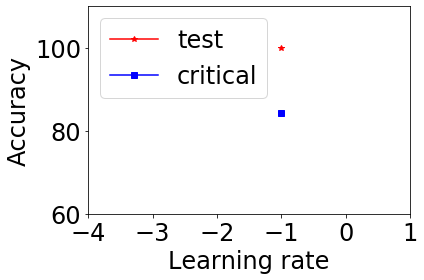

In [10]:
from matplotlib import pyplot as plt

## Print the result for different N
%matplotlib inline

plt.plot(np.log10([10**-1]), test_array, 'r-*', label="test")
plt.plot(np.log10([10**-1]), critical_array, 'b-s', label="critical")
plt.ylim(60,110)
plt.xlabel('Learning rate', fontsize=24)
plt.xticks(np.log10(lr_array))
plt.ylabel('Accuracy', fontsize=24)
plt.legend(loc='best', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.show()